In [1]:
import pandas as pd

df = pd.read_csv('data/apple_stock_5y.csv')
df

,Date,Close/Last,Volume,Open,High,Low
0,10/03/2024,$225.67,34044160,$225.14,$226.805,$223.32
1,10/02/2024,$226.78,32880610,$225.89,$227.37,$223.02
2,10/01/2024,$226.21,63285050,$229.52,$229.65,$223.74
3,09/30/2024,$233.00,54793390,$230.04,$233.00,$229.65
4,09/27/2024,$227.79,34025970,$228.46,$229.52,$227.30
...,...,...,...,...,...,...
1253,10/10/2019,$57.5225,115851920,$56.9825,$57.61,$56.825
1254,10/09/2019,$56.7575,76117680,$56.7575,$56.9475,$56.41
1255,10/08/2019,$56.10,117130800,$56.455,$57.015,$56.0825
1256,10/07/2019,$56.765,123557080,$56.5675,$57.4825,$56.46


In [2]:
df["Close/Last"] = df["Close/Last"].apply(lambda x: float(x[1:]))
df

,Date,Close/Last,Volume,Open,High,Low
0,10/03/2024,225.6700,34044160,$225.14,$226.805,$223.32
1,10/02/2024,226.7800,32880610,$225.89,$227.37,$223.02
2,10/01/2024,226.2100,63285050,$229.52,$229.65,$223.74
3,09/30/2024,233.0000,54793390,$230.04,$233.00,$229.65
4,09/27/2024,227.7900,34025970,$228.46,$229.52,$227.30
...,...,...,...,...,...,...
1253,10/10/2019,57.5225,115851920,$56.9825,$57.61,$56.825
1254,10/09/2019,56.7575,76117680,$56.7575,$56.9475,$56.41
1255,10/08/2019,56.1000,117130800,$56.455,$57.015,$56.0825
1256,10/07/2019,56.7650,123557080,$56.5675,$57.4825,$56.46


In [3]:
import torch

lookback = 5
timeseries = df[["Close/Last"]].values.astype('float32')

X, y = [], []
for i in range(len(timeseries)-lookback):
    feature = timeseries[i:i+lookback]
    target = timeseries[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)
    
X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape, y.shape)

torch.Size([1253, 5, 1]) torch.Size([1253, 5, 1])


/var/folders/w1/zwrpgwxs31sdg4vjycy2zwlc0000gn/T/ipykernel_14656/2469697612.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X)


In [4]:
import torch.nn as nn

class StockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = StockModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=8)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        rmse = np.sqrt(loss_fn(y_pred, y))
    print(f"Epoch {epoch}: RMSE {rmse:.4f}")

Epoch 0: RMSE 143.1433
Epoch 100: RMSE 3.0862
Epoch 200: RMSE 2.9258
Epoch 300: RMSE 2.7086
Epoch 400: RMSE 2.9002
Epoch 500: RMSE 2.7274
Epoch 600: RMSE 3.0003
Epoch 700: RMSE 2.8142
Epoch 800: RMSE 2.7263
Epoch 900: RMSE 2.6808


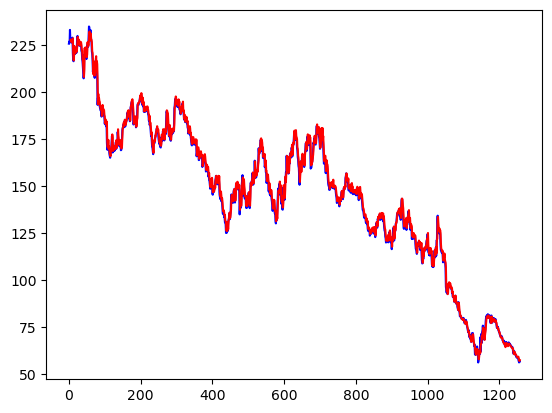

In [6]:
import matplotlib.pyplot as plt

with torch.no_grad():
    pred_series = np.ones_like(timeseries) * np.nan
    pred_series[lookback:] = model(X)[:, -1, :]

plt.plot(timeseries, c='b')
plt.plot(pred_series, c='r')
plt.show()

In [7]:
error = abs(timeseries-pred_series)
error

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [1.3290482 ],
       [0.13461304],
       [0.58955383]], dtype=float32)

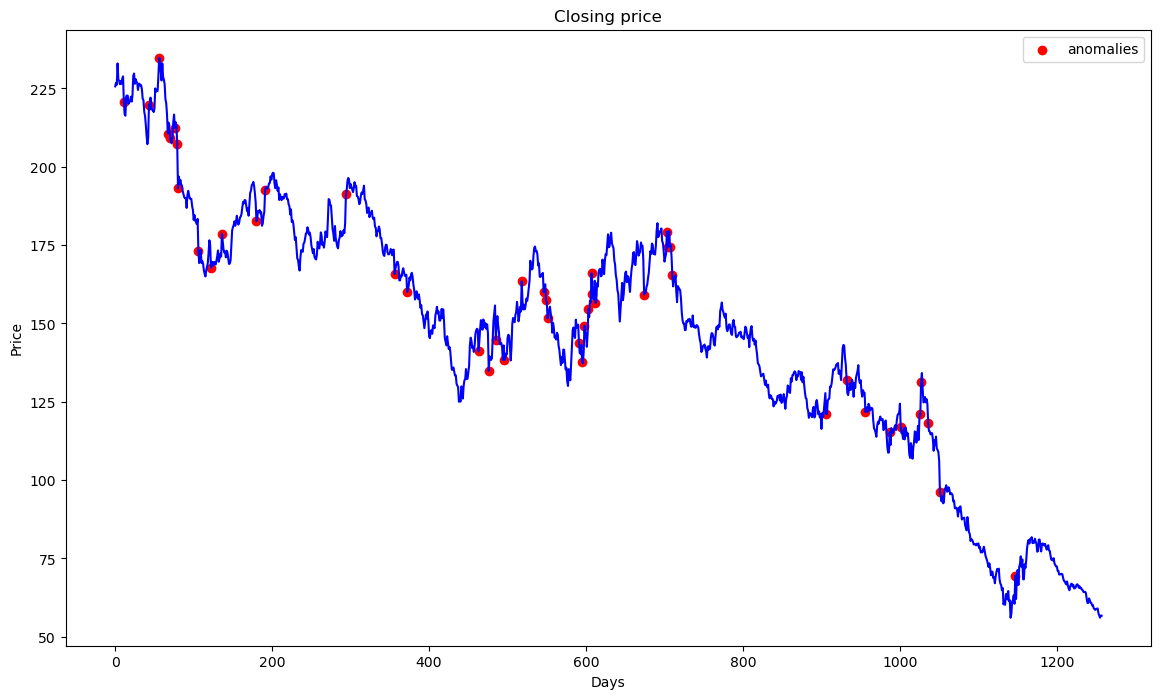

In [8]:
threshold = 6
error_series = pd.Series(error.flatten())
price_series = pd.Series(timeseries.flatten())

anomalies_filter = error_series.apply(lambda x: True if x > threshold else False)
anomalies = price_series[anomalies_filter]

plt.figure(figsize=(14, 8))
plt.scatter(x=anomalies.index, y=anomalies, color="red", label="anomalies")
plt.plot(df.index, timeseries, color='blue')
plt.title('Closing price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
